# Cifar-10 Classification using Keras Tutorial

The CIFAR-10 data set consists of 60000 32×32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Recognizing photos from the cifar-10 collection is one of the most common problems in the today’s  world of machine learning. I’m going to show you – step by step – how to build multi-layer artificial neural networks that will recognize images from a cifar-10  set with an accuracy of about 80% and visualize it.

In [1]:
# Import all modules
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.constraints import maxnorm
from keras.optimizers import Adam, SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from keras import backend as K

# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from scipy.misc import toimage

import cv2
from PIL import Image 

import itertools

import numpy as np
np.random.seed(1337) # for reproducibility

Using TensorFlow backend.


In [3]:
def plot_images(images, labels_true, class_names, labels_pred=None):

    assert len(images) == len(labels_true)

    # Create a figure with sub-plots
    fig, axes = plt.subplots(3, 3, figsize = (8,8))

    # Adjust the vertical spacing
    if labels_pred is None:
        hspace = 0.2
    else:
        hspace = 0.5
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Fix crash when less than 9 images
        if i < len(images):
            # Plot the image
            ax.imshow(images[i], interpolation='spline16')
            
            # Name of the true class
            z = 1*labels_true[i].tolist()
            labels_true_name = class_names[z.index(max(z))]

            # Show true and predicted classes
            if labels_pred is None:
                xlabel = "True: "+labels_true_name
            else:
                # Name of the predicted class
                labels_pred_name = class_names[labels_pred[i]]

                xlabel = "True: "+labels_true_name+"\nPredicted: "+ labels_pred_name

            # Show the class on the x-axis
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Show the plot
    return plt.show()

In [4]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Set background to white
    fig.patch.set_facecolor('white')
    axs[0].patch.set_facecolor('white')
    axs[1].patch.set_facecolor('white')
    
    # Don't allow the axis to be on top of your data
    axs[0].set_axisbelow(True)
    axs[1].set_axisbelow(True)
    
    # Customize the grid
    axs[0].grid(linestyle='-', linewidth='0.2', color='grey')
    axs[1].grid(linestyle='-', linewidth='0.2', color='grey')
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),
                model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),
                model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),
                      len(model_details.history['acc'])/10)
    axs[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),
                model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),
                model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),
                      len(model_details.history['loss'])/10)
    axs[1].legend(['Training loss', 'Validation Loss'], loc='best')
    
    # Show the plot
    return plt.show()

In [5]:
def predict_classes(model, images_test, labels_test):
    
    # Predict class of image using model
    class_pred = model.predict(images_test, batch_size=32)

    # Convert vector to a label
    labels_pred = np.argmax(class_pred,axis=1)
    labels_true = np.argmax(labels_test,axis=1)

    # Check which labels have been predicted correctly
    # Boolean array that tell if predicted label is the true label
    correct = (labels_pred == labels_true)
    print("Number of correct predictions: %d" % sum(correct))

    
    # Array which tells if the prediction is correct or not
    # And predicted labels
    return correct, labels_pred

In [6]:
def visualize_errors(images_test, labels_test, class_names, labels_pred, correct):
    
    incorrect = (correct == False)
    
    # Images of the test-set that have been incorrectly classified.
    images_error = images_test[incorrect]
    
    # Get predicted classes for those images
    labels_error = labels_pred[incorrect]

    # Get true classes for those images
    labels_true = labels_test[incorrect]
    
    
    # Plot the first 9 images.
    return plot_images(images=images_error[0:9],
                       labels_true=labels_true[0:9],
                       class_names=class_names,
                       labels_pred=labels_error[0:9])

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt.show()

In [8]:
# Set callback functions to early stop training if a convergence criteria is met (e.g no improvement after 5 epochs)
# and save the best model so far 
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Save the model after every epoch
check_point = ModelCheckpoint(filepath='best_model.h5',  # model filename
                              monitor='val_loss',        # quantity to monitor
                              verbose=0,                 # verbosity - 0 or 1
                              save_best_only= True,      # The latest best model will not be overwritten
                              mode='auto')               # The decision to overwrite model is made 
                                                         # automatically depending on the quantity to monitor

## Load CIFAR-10 dataset

Next, we can load the CIFAR-10 data set provided by Keras.

The test batch contains exactly 1000 randomly-selected images from each class.

The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another.

Between them, the training batches contain exactly 5000 images from each class.

We can fit this model with 25 epochs and a batch size of 32. A small number of epochs was chosen to help keep this tutorial moving. Normally the number of epochs would be one or two orders of magnitude larger and batch size (e.g. 128) for this problem.

In [9]:
# number of images used in each optimization step
batch_size = 25 

# number of one forward and one backward pass of all the training data
epochs = 32

# one class per digit
num_classes = 10

# input image dimensions (image resolution)
img_rows, img_cols = 32, 32

# input shape
input_shape = (img_rows, img_cols, 1)

# number of convolutional filters to use
filters = 32

# size of pooling area for max pooling
nb_pool = 2

# convolution kernel size
nb_conv = 3

# optimisation parameters
learning_rate = 0.0001
droprate      = 0.25

In [10]:
# Download and process your dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [11]:
# Here are the classes in the dataset, as well as 10 random images from each
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

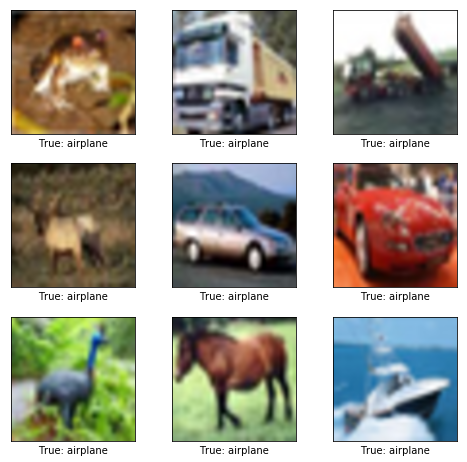

In [12]:
# Get the first images from the train-set.
images_train = x_train[0:9]

# Get the true classes for those images.
labels_true = y_train[0:9]

# Plot the images and labels.
plot_images(images=images_train, labels_true=labels_true, class_names=class_names)

In [13]:
# Print figure with 10 random images from each
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    return plt.show()

/home/chrisjcc/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


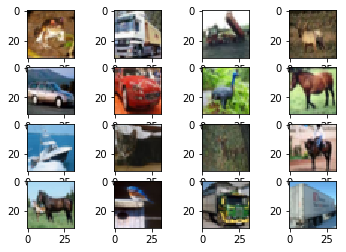

In [14]:
show_imgs(x_train)

In [15]:
# Add the depth in the input. Only grayscale so depth is only one
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test  = x_test.reshape(x_test.shape[0], 3,   img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test  = x_test.reshape(x_test.shape[0],   img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

The pixel values are in the range of 0 to 255 for each of the red, green and blue channels.

It is good practice to work with normalized data. Because the input values are well understood, we can easily normalize to the range 0 to 1 by dividing each value by the maximum observation which is 255.

Note, the data is loaded as integers, so we must cast it to floating point values in order to perform the division.

In [16]:
# Change to float datatype
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# Normalize inputs from 0-255 to 0-1
x_train /= 255
x_test /= 255

In [17]:
# Display the shapes to check if everything's ok
print("Number of training samples: %d" % x_train.shape[0])
print("Number of test samples: %d" % x_test.shape[0])
print("Image rows: %d" % x_train.shape[1])
print("Image columns: %d" % x_train.shape[2])
print("Number of classes: %d" % num_classes)

Number of training samples: 50000
Number of test samples: 10000
Image rows: 32
Image columns: 32
Number of classes: 10


We can use a one hot encoding to transform them into a binary matrix in order to best model the classification problem. We know there are 10 classes for this problem, so we can expect the binary matrix to have a width of 10.

In [18]:
# Convert class vectors to binary class matrices (ie one-hot encoded vectors)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

## Additional information

### Max Pooling Layer

Pooling layer is mostly used immediately after the convolutional layer to reduce the spatial size (only width and height, not depth). This reduces the number of parameters, hence computation is reduced. Using fewer parameters avoids overfitting.

Note: Overfitting is the condition when a trained model works very well on training data, but does not work very well on test data.

### Regularization

Deep neural nets with a large number of parameters are very powerful machine learning systems. However, overfitting is a serious problem in such networks.  

- **Dropout:** the key idea is to randomly drop units (along with their connections) from the neural network during training. The reduction in number of parameters in each step of training has effect of regularization. Dropout has shown improvements in the performance of neural networks on supervised learning tasks in vision, speech recognition, document classification and computational biology, obtaining state-of-the-art results on many benchmark data sets.

- **Kernel_initializer:** it allows to apply penalties on layer parameters during optimization. These penalties are incorporated in the loss function that the network optimizes. This argument in convolutional layer can be for example L2 regularisation of the weights (or random_uniform, glorot_normal, he_normal). This penalizes spiky weights and makes sure that all the inputs are considered. During gradient descent parameter update, the above L2 regularization ultimately means that every weight is decayed linearly, that’s why called weight decay.

- **BatchNormalization:**  normalizes the activation of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. It addresses the problem of internal covariate shift. It also acts as a regularizer, in some cases eliminating the need for Dropout. Batch Normalization achieves the same accuracy with fewer training steps thus speeding up the training process.

In [19]:
# For example to constructor
def create_model(input_shape=(32, 32, 3)):
    # Start neural network
    model = Sequential()
  
    # Add input convolutional layer with a ReLU activation function
    model.add(Conv2D(32, (3, 3), padding='same', 
                     activation='relu', input_shape=input_shape))
    # Add convolutional layer with a ReLU activation function
    model.add(Conv2D(32, (3, 3), activation='relu'))
    # Add pooling layer (e.g. max pooling) with 2x2 patch
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add dropout layer
    model.add(Dropout(0.25))
 
    # Add convolutional layer with a ReLU activation function
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    # Add convolutional layer with a ReLU activation function
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Add pooling layer (e.g. max pooling) with 2x2 patch
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add dropout layer
    model.add(Dropout(0.25))
 
    # Add convolutional layer with a ReLU activation function
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    # Add convolutional layer with a ReLU activation function
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Add pooling layer (e.g. max pooling) with 2x2 patc
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add dropout layer
    model.add(Dropout(0.25))
 
    # Add fully connected layer with a ReLU activation function
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    # Add dropout layer
    model.add(Dropout(0.5))
    #model.add(Dense(num_classes, activation='softmax'))
    
    model.add(Dropout(0.5))
    # 12. Fully connected output layer with 10 units and a softmax activation function
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
   
    # Print model summary
    model.summary()
    
    # Compile neural network
    model.compile(optimizer='rmsprop',  # root Mean Square Propagation
                  loss='categorical_crossentropy',  # cross-entropy
                  metrics=['accuracy'] # accuracy performance metric
                  )
    
    return model  

In [20]:
model = create_model()
model_history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=5,#epochs,
                          validation_split=0.20,
                          shuffle=True
                         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [21]:
# Evaluate the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 56.32%


The classification accuracy and loss is printed each epoch on both the training and test datasets. The model is evaluated on the test set and achieves an accuracy hopefully above 50%.

We can improve the accuracy significantly by creating a much deeper network. This is what we will look at in the next section.

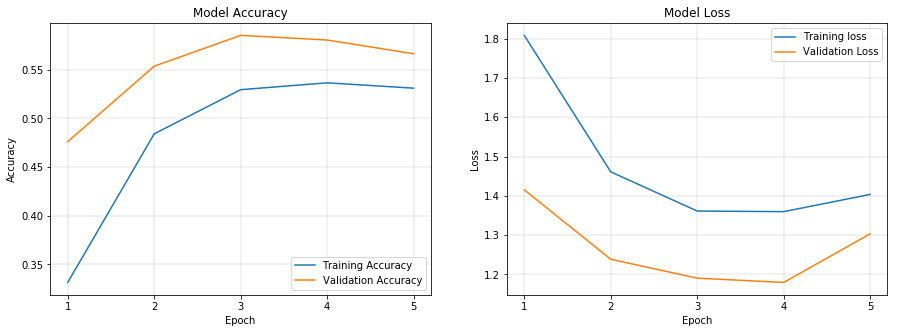

In [22]:
# Model accuracy and loss plots
plot_model(model_history)

**Confusion matrix** – also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).

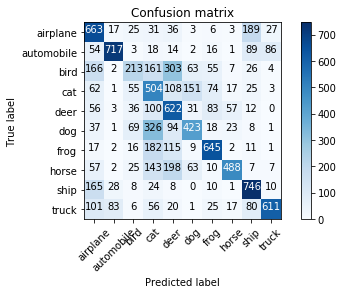

In [25]:
# Predict class of image using model
y_pred = model.predict(x_test, batch_size=32)

# Convert vector to a label
labels_pred = np.argmax(y_pred,axis=1)
labels_true = np.argmax(y_test,axis=1)

# Confusion matrix result  
cm = confusion_matrix(labels_true, labels_pred)

plot_confusion_matrix(cm, class_names, normalize=False)

In [27]:
correct, labels_pred = predict_classes(model, x_test, y_test)

Number of correct predictions: 5632


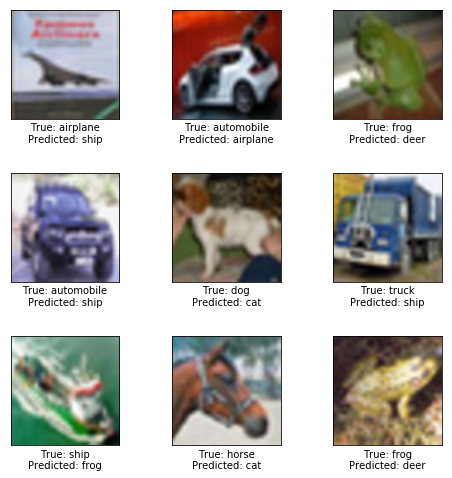

In [28]:
# Plot the first 9 mis-classified images
visualize_errors(x_test, y_test, class_names, labels_pred, correct)

## Improve Model Performance

We have achieved good results on this very complex problem, but we are still a good way from achieving world class results.  In this section we look at scaling up the size and complexity of our model.

Below are some ideas that you can try to extend upon the models and improve model performance.

- **Train for More Epochs**. Each model was trained for a very small number of epochs, 25. It is common to train large convolutional neural networks for hundreds or thousands of epochs. I would expect that performance gains can be achieved by significantly raising the number of training epochs.

- **Deeper Network Topology**. The larger network presented is deep, but larger networks could be designed for the problem. This may involve more feature maps closer to the input and perhaps less aggressive pooling. Additionally, standard convolutional network topologies that have been shown useful may be adopted and evaluated on the problem. Below we will try deeper networks and also try a couple of state-of-the-art image recognition architectures, e.g. VGG-16 and  AlexNet.

- **Image Data Augmentation**. The objects in the image vary in their position. Another boost in model performance can likely be achieved by using some data augmentation. Methods such as standardization and random shifts and horizontal image flips may be beneficial.

### Build fist variant 4-layer model

In [29]:
# 4-layer cnn model
def base_4_layer_model(input_shape=(32, 32, 3)):
 
    # 0. Start Sequential model
    model = Sequential()
  
    # 1. Convolutional input layer, 32 feature maps with a size of 3×3, a ReLU activation function
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     input_shape=input_shape))
    model.add(Activation('relu'))
    # 2. Convolutional input layer, 32 feature maps with a size of 3×3, a ReLU activation function
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3)))
    model.add(Activation('relu'))
    # 3. Max Pool layer with size 2×2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 4. Dropout set to 25%
    model.add(Dropout(0.25))
    # 5. Convolutional input layer, 64 feature maps with a size of 3×3, a ReLU activation function
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     padding='same'))
    model.add(Activation('relu'))
    # 6. Convolutional input layer, 64 feature maps with a size of 3×3, a ReLU activation function
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3)))
    model.add(Activation('relu'))
    # 7. Max Pool layer with size 2×2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 8. Dropout set to 25%
    model.add(Dropout(0.25))
 
    # 9. Flatten layer
    model.add(Flatten())
    
    # 10. Fully connected layer with 512 units and a ReLU activation function
    model.add(Dense(512))
    model.add(Activation('relu'))
    # 11. Dropout set to 50%
    model.add(Dropout(0.5))
    # 12. Fully connected output layer with 10 units and a softmax activation function
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    # 13. A logarithmic loss function is used with the stochastic gradient 
    # descent optimization algorithm configured with a large momentum and 
    # weight decay start with a learning rate of 0.1.
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
 
    model.summary()
 
    model.compile(loss='categorical_crossentropy', 
                  optimizer=sgd, 
                  metrics=['accuracy'])
  
    return model

In [30]:
# Create model
cnn_4_layer_model = base_4_layer_model()

# Fit model
history_cnn_4_layer_model = cnn_4_layer_model.fit(x_train, y_train,
                                                  batch_size=batch_size,
                                                  epochs=epochs,
                                                  validation_split=0.20,
                                                  shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [33]:
# Evaluate model
scores = cnn_4_layer_model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 3s 317us/step
Test result: 70.780 loss: 0.903


### Build second variant of 6-layer model

In [37]:
# 6-layer cnn model
def base_6_layer_model(input_shape=(32, 32, 3)):
  
    # 0. Start Sequetial model
    model = Sequential()
    # 1. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    # 2. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    # 3. Max Pool layer with size 2×2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 4. Dropout set to 25%
    model.add(Dropout(0.25))

    # 5. Convolutional input layer, 64 feature maps with a size of 3×3, a rectifier activation function
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    # 6. Convolutional input layer, 64 feature maps with a size of 3×3, a rectifier activation function
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    # 7. Max Pool layer with size 2×2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 8. Dropout set to 25%
    model.add(Dropout(0.25))

    # 9. Flatten layer
    model.add(Flatten())
    # 10. Fully connected layer with 512 units and a rectifier activation function
    model.add(Dense(512))
    model.add(Activation('relu'))
    # 11. Dropout set to 50%
    model.add(Dropout(0.5))
    # 12. Fully connected output layer with 10 units and a softmax activation function
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # 13. Model summary
    model.summary()
    
    # 14. A logarithmic loss function is used with the stochastic gradient descent 
    # optimization algorithm configured with a large momentum and weight decay 
    # start with a learning rate of 0.1.
    sgd = SGD(lr = 0.1, decay=1e-6, momentum=0.9, nesterov=True)

    # 15. Compile model use categorical cross entropy and accuracy for validation metric
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [38]:
# Create model
cnn_6_layer_model = base_6_layer_model()

# Fit model
history_cnn_6_layer_model = cnn_6_layer_model.fit(x_train, y_train,
                                                  batch_size=batch_size,
                                                  epochs=epochs,
                                                  validation_split=0.20,
                                                  shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [39]:
# Evaluate model
scores = cnn_6_layer_model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 3s 326us/step
Test result: 10.000 loss: 2.311


## Try 2 state-of-the-art CNN architectures

###  VGG-16 architectures

VGG16 was publised in 2014 and is one of the simplest (among the other cnn architectures used in Imagenet competition). It's Key Characteristics are:


1.   This network contains total 16 layers in which weights and bias parameters are learnt.
2.   A total of 13 convolutional layers are stacked one after the other and 3 dense layers for classification.
3.   The number of filters in the convolution layers follow an increasing pattern (similar to decoder architecture of autoencoder).
4.   The informative features are obtained by max pooling layers applied at different steps in the architecture.
5.   The dense layers comprises of 4096, 4096, and 1000 nodes each (can use 10 instead).
6.   The cons of this architecture are that it is slow to train and produces the model with very large size.

![Image of VGG-16](https://qph.fs.quoracdn.net/main-qimg-83c7dee9e8b039c3ca27c8dd91cacbb4)

In [41]:
def build_vgg16_model(input_shape=(32, 32, 3)):
    # input layer
    inputs = Input(shape=input_shape, name='input')
  
    conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(inputs)
    conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
    pool1  = MaxPooling2D((2, 2))(conv2)

    conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
    conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
    pool2  = MaxPooling2D((2, 2))(conv4)

    conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
    conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
    conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
    pool3  = MaxPooling2D((2, 2))(conv7)

    conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
    conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
    conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
    pool4  = MaxPooling2D((2, 2))(conv10)

    conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
    conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
    conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
    pool5  = MaxPooling2D((2, 2))(conv13)

    flat   = Flatten()(pool5)
    dense1 = Dense(4096, activation="relu")(flat)
    dense2 = Dense(4096, activation="relu")(dense1)
    output = Dense(10, activation="softmax")(dense2)
  
    model  = Model(inputs=inputs, outputs=output)
    
    model.summary()
    
    # optimizer
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
  
    model.compile(loss='categorical_crossentropy', 
                  optimizer=sgd, 
                  metrics=['accuracy'])
    return model

In [ ]:
vgg16_model = build_vgg16_model()
history_vgg16_model = vgg16_model.fit(x_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      validation_split=0.20,
                                      shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 128)         0         
__________

In [ ]:
# Evaluate model
scores = vgg16_model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

### AlexNet architectures

contains 8 layers of transformations, five convolutional layers followed by two fully connected hidden layers and an output layer.

The convolutional kernels in the first convolutional layer are reasonably large at 11×1111×11, in the second they are 5×55×5 and thereafter they are 3×33×3. Moreover, the first, second, and fifth convolutional layers are each followed by overlapping pooling operations with pool size 3×33×3 and stride (2×22×2).

Following the convolutional layers, the original AlexNet had fully-connected layers with 4096 nodes each.

![Image of AlexNet](https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0106.png)

In [ ]:
def build_alexnet_model(input_shape=(32, 32, 3)):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPool2D(pool_size=3, strides=2))

    # Second convolutional layer
    model.add(Conv2D(filters=192, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=3, strides=(2,2)))

    # Third convolutional layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu'))

    # Fourth convolutional layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu'))

    # Fifth convolutional layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size==(3,3), strides=2))

    # Flatten and apply fullly connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(4096, activation="relu"))
  
    model.summary()
  
    model.compile(loss="categorical_crossentropy", 
                  optimizer='adadelta', 
                  metrics=["accuracy"])
  
  return model

In [ ]:
alexnet_model = build_alexnet_model()
history_alexnet_model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_split=0.20,
                          shuffle=True)

VGG16 makes the improvement over AlexNet by replacing large kernel-sized filters(11 and 5 in the first and second convolutional layer, respectively) with multiple 3X3 kernel-sized filters one after another. Having multiple stacked smaller size kernel is better than the one with a larger size kernel because multiple non-linear layers increases the depth of the network which enables it to learn more complex features, and that too at a lower cost. 

We can say from the above that the initial layers are looking at smaller regions of the image and thus can only learn simple features like edges / corners etc. As we go deeper into the network, the neurons get information from larger parts of the image and from various other neurons. Thus, the neurons at the later layers can learn more complicated features e.g. wheels, windows, etc.

From the above curves, we can see that there is a considerable difference between the training and validation loss. This indicates that the network has tried to memorize the training data and thus, is able to get better accuracy on it. This is a sign of Overfitting. But we have already used Dropout in the network, then why is it still overfitting. Let us see if we can further reduce overfitting using something else.

## Data Augmentation

In Keras, We have a ImageDataGenerator class that is used to generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely. The image data is generated by transforming the actual training images by rotation, crop, shifts, shear, zoom, flip, reflection, normalization etc. The below code snippets shows how to initialize the image data generator class.

In [ ]:
# First step pick the CNN architecture selected for model improvement
def cnn_model(input_shape=(32,32,3)):
    
    model = Sequential()
    
    model.add(Conv2D(filters=96, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=input_shape))    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=96, kernel_size=(3, 3), activation='relu', padding = 'same'))  
    model.add(Conv2D(filters=96, kernel_size=(3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(filters=192, kernel_size=(3, 3), activation='relu', padding = 'same'))    
    model.add(Conv2D(filters=192, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model.add(Conv2D(filters=192, kernel_size=(3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))    
    
    model.add(Conv2D(filters=192, kernel_size=(3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=192, kernel_size=(1, 1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=10, kernel_size=(1, 1), padding='valid'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    
    # Configure the model for training
    model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
                  optimizer=Adam(lr=1.0e-4), # Adam optimizer with 1.0e-4 learning rate
                  metrics = ['accuracy'])   # Metrics to be evaluated by the model
    
    return model

In [ ]:
# Instatiate model
model = cnn_model()

In [ ]:
# Define a data generature function ready for fitting on data
def create_datagen(x, y, rescale=None, batch_size=64):
    # Data augmentation to have random shifts, rotations and flips, thus increasing the size of the dataset.
    image_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,   # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,     # apply ZCA whitening
        rotation_range=45,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images horizontally
        vertical_flip=False)     # randomly flip images vertically
  
    # Generate augmented data
    data_generator = image_generator.flow(x, y, batch_size=batch_size)
  
    return data_generator

In [ ]:
# visualizing the images generated using flow method of ImageDataGenerator class.

# Configure batch size and retrieve one batch of images
for X_batch, y_batch in create_datagen(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(toimage(X_batch[i].reshape(img_rows, img_cols, 3)))
    # show the plot
    plt.show()
    break

In [ ]:
# Flow generates batches of data, after performing the data transformations and
# augmentation specified during the instantiation of the data generator.
train_generator = create_datagen(x_train, y_train, batch_size=64)

# this is the augmentation configuration we will use for testing (only rescaling)
test_generator  = create_datagen(x_test, y_test, rescale=1./255, batch_size=64)

In [ ]:
# Fit the model on the data provided
model.fit_generator(train_generator,
                    steps_per_epoch=x_train.shape[0] // batch_size,  # number of samples per gradient update
                    epochs=5, # number of iterations
                    validation_data=test_generator, #(x_test,y_test)
                    verbose=1, #10
                    callbacks=[check_point, early_stopping]
                   )

In [ ]:
# Evaluate model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

### How to construct Scikit-learn classifier from Keras model

Let’s get started.

In this section, I want to show you how to wrap Keras models for use in scikit-learn and how to use grid search hyper-parameters, such as learning rate, dropout rate, epochs and number of neurons.


To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class.


The constructor for the KerasClassifier class can take default arguments that are passed on to the calls to model.fit(), such as the number of epochs and the batch size. But can also take new argument, e.g. number of layers, to be passed to your custom create_model() function with default values.


For example:

> model = KerasClassifier(build_fn=create_model,  epochs=10, dropout_rate=0.2)


### How to Use Grid Search in scikit-learn

Grid search is a model hyperparameter optimization technique. In scikit-learn this technique is provided in the GridSearchCV class.

When constructing this class you must provide a dictionary of hyperparameters to evaluate in the param_grid argument. This is a map of the model parameter name and an array of values to try.

By default, accuracy is the score that is optimized, but other scores can be specified in the score argument of the GridSearchCV constructor.

The GridSearchCV process will then construct and evaluate one model for each combination of parameters. Cross validation is used to evaluate each individual model and the default of 3-fold cross validation is used, although this can be overridden by specifying the cv argument to the GridSearchCV constructor.

In [ ]:
# Define custom build CNN architecture
def build_fn(input_shape=(32, 32, 3), kernel_initializer='he_uniform', optimizers='adam'):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                     kernel_initializer=kernel_initializer, 
                     input_shape=input_shape))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                     kernel_initializer=kernel_initializer))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
 
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                     kernel_initializer=kernel_initializer))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                     kernel_initializer=kernel_initializer))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
 
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                     kernel_initializer=kernel_initializer))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                     kernel_initializer=kernel_initializer))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
 
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
 
    model.summary()
  
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers, 
                  metrics=['acc'])

    return model

In [ ]:
# Create Scikit-learn classifier for Keras model
estimator = KerasClassifier(build_fn=build_fn, 
                            epochs=10,
                            batch_size=128,
                            kernel_initializer='he_normal')

In [ ]:
# Define grid search epochs, batch size, kernel initializer, dropout, and optimizer
optimizers = ['rmsprop', 'adam']
kernel_initializer = ['glorot_uniform', 'he_normal', 'uniform']
epochs = [5, 10, 20]
batches = [64, 128, 256]
dropout_rate = [0.1, 0.2, 0.4]

param_grid = dict(optimizer=optimizers, 
                  epochs=epochs, 
                  batch_size=batches, 
                  kernel_initializer=kernel_initializer)


grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           n_jobs=1)


In [ ]:
# Fit model
grid_result = grid_search.fit(x_train, y_train)

### Evaluate The Model with k-Fold Cross Validation

The scikit-learn has excellent capability to evaluate models using a suite of techniques. The gold standard for evaluating machine learning models is k-fold cross validation.

First we can define the model evaluation procedure. Here, we set the number of folds to be 5 (10 is usually an excellent default) and to shuffle the data before partitioning it.

Evaluating the model will take a long while and returns an object that describes the evaluation of the 5 constructed models for each of the splits of the dataset.

In [ ]:
# Evaluate using 15-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Alternative k-fold cross validated type
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [ ]:
# Model performance
results = cross_val_score(estimator, x_train, y_ttrain, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
y_true = y_test
y_pred = np.argmax(grid_result.fit(x_test, y_test),axis=1)
classification_report(y_true, y_pred, target_names=class_names)

## Summary

In this tutorial you discovered how to create state-of-the-art  deep learning models in Keras for object recognition in photographs.

After working through this tutorial you learned:

- What is Keras library and how to use it.
-  How to use the CIFAR-10 dataset and how to load it in Keras and plot ad hoc examples from the dataset.
- What is Convolutional Neural Networks (CNN)
- How to build step by step CNN
- How to train and evaluate CNN on the problem.
- How to expand a simple CNN into a deep architector in order to boost performance on the difficult problem.
- What are differences in model results and how to visualize it using confusion matrix, loss and accuracy metric plots
- How to use data augmentation to get a further boost on the difficult object recognition problem.
